In [1]:
!pip install torch>=1.2.0
!pip install torchaudio
%matplotlib inline

     |████████████████████████████████| 6.7MB 567kB/s 



Torchaudio Tutorial
===================

PyTorch is an open source deep learning platform that provides a
seamless path from research prototyping to production deployment with
GPU support.

Significant effort in solving machine learning problems goes into data
preparation. torchaudio leverages PyTorch’s GPU support, and provides
many tools to make data loading easy and more readable. In this
tutorial, we will see how to load and preprocess data from a simple
dataset.

For this tutorial, please make sure the ``matplotlib`` package is
installed for easier visualization.




In [2]:
import torch
import torchaudio
import matplotlib.pyplot as plt

Open, Visualize a Speech File and Study it's properties
-----------------




torchaudio supports loading sound files in the wav and mp3 format. We
call waveform the resulting raw audio signal.




Shape of waveform: torch.Size([2, 276858])
Sample rate of waveform: 44100
 Number of Channels : 2


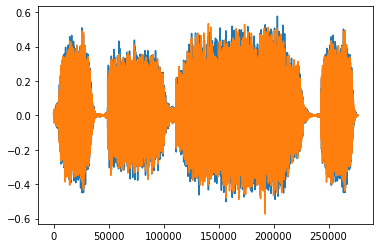

In [25]:
import requests

url = "https://pytorch.org/tutorials//_static/img/steam-train-whistle-daniel_simon-converted-from-mp3.wav"
r = requests.get(url)

with open('steam-train-whistle-daniel_simon-converted-from-mp3.wav', 'wb') as f:
    f.write(r.content)

filename = "steam-train-whistle-daniel_simon-converted-from-mp3.wav"
waveform, sample_rate = torchaudio.load(filename)

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))
print(" Number of Channels : {}".format(waveform.size()[0]))

plt.figure()
plt.plot(waveform.t().numpy())

**Let's Resample audio from Channel 1**

Shape of transformed waveform: torch.Size([1, 2769])


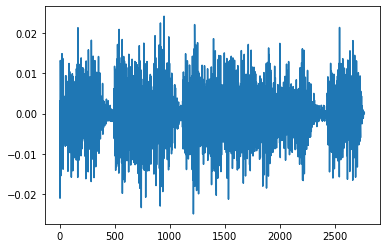

In [4]:
new_sample_rate = sample_rate/100

# Since Resample applies to a single channel, we resample first channel here
channel = 0
transformed = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(waveform[channel,:].view(1,-1))

print("Shape of transformed waveform: {}".format(transformed.size()))

plt.figure()
plt.plot(transformed[0,:].numpy())

Transformations
---------------
-  **Spectrogram**: Create a spectrogram from a waveform.
-  **AmplitudeToDB**: This turns a spectrogram from the
   power/amplitude scale to the decibel scale.
-  **MelScale**: This turns a normal STFT into a Mel-frequency STFT,
   using a conversion matrix.
-  **MFCC**: Create the Mel-frequency cepstrum coefficients from a
   waveform.
-  **MelSpectrogram**: Create MEL Spectrograms from a waveform using the
   STFT function in PyTorch.
-  **MuLawEncoding**: Encode waveform based on mu-law companding.
-  **MuLawDecoding**: Decode mu-law encoded waveform.





To start, we can look at the log of the spectrogram on a log scale.




Shape of spectrogram: torch.Size([2, 201, 1385])


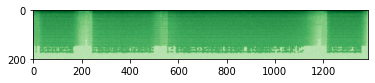

In [5]:
specgram = torchaudio.transforms.Spectrogram()(waveform)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
p = plt.imshow(specgram.log2()[0,:,:].detach().numpy(), cmap='Greens')



Let's change the amplitude to Decible scale

Shape of spectrogram: torch.Size([2, 201, 1385])


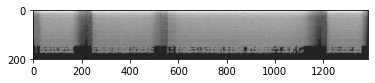

In [6]:
specgram1 = torchaudio.transforms.AmplitudeToDB()(specgram)

print("Shape of spectrogram: {}".format(specgram1.size()))

plt.figure()
p = plt.imshow(specgram1[0,:,:].detach().numpy(), cmap='gray')

In [7]:
print("See the change in values when converted to Decible scale")
print(specgram[0][1])
print(specgram1[0][1])

See the change in values when converted to Decible scale
tensor([2.4972e-01, 3.6223e+00, 2.3963e+00,  ..., 3.2012e-03, 2.1105e-04,
        2.1794e-05])
tensor([ -6.0254,   5.5898,   3.7955,  ..., -24.9468, -36.7561, -46.6167])


Let's look into MFCC features of the audio

In [8]:
mfcc=torchaudio.transforms.MFCC()(waveform)
print("Shape:{}".format(mfcc.size()))

Shape:torch.Size([2, 40, 1385])


Or we can look at the Mel Spectrogram on a log scale.




Shape of spectrogram: torch.Size([2, 128, 1385])


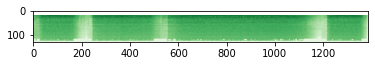

In [9]:
specgram = torchaudio.transforms.MelSpectrogram()(waveform)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
p = plt.imshow(specgram.log2()[0,:,:].detach().numpy(), cmap='Greens')

As another example of transformations, we can encode the signal based on
Mu-Law enconding. But to do so, we need the signal to be between -1 and
1. Since the tensor is just a regular PyTorch tensor, we can apply
standard operators on it.




In [10]:
# Let's check if the tensor is in the interval [-1,1]
print("Min of waveform: {}\nMax of waveform: {}\nMean of waveform: {}".format(waveform.min(), waveform.max(), waveform.mean()))

Min of waveform: -0.572845458984375
Max of waveform: 0.575958251953125
Mean of waveform: 9.293758921558037e-05


Since the waveform is already between -1 and 1, we do not need to
normalize it.




In [11]:
def normalize(tensor):
    # Subtract the mean, and scale to the interval [-1,1]
    tensor_minusmean = tensor - tensor.mean()
    return tensor_minusmean/tensor_minusmean.abs().max()

# Let's normalize to the full interval [-1,1]
# waveform = normalize(waveform)

Let’s apply encode the waveform.




Shape of transformed waveform: torch.Size([2, 276858])


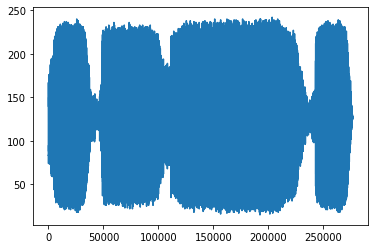

In [12]:
transformed = torchaudio.transforms.MuLawEncoding()(waveform)

print("Shape of transformed waveform: {}".format(transformed.size()))

plt.figure()
plt.plot(transformed[0,:].numpy())

And now decode.




Shape of recovered waveform: torch.Size([2, 276858])


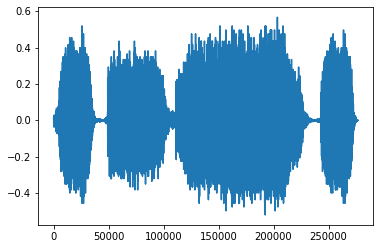

In [13]:
reconstructed = torchaudio.transforms.MuLawDecoding()(transformed)

print("Shape of recovered waveform: {}".format(reconstructed.size()))

plt.figure()
plt.plot(reconstructed[0,:].numpy())

We can finally compare the original waveform with its reconstructed
version.




In [14]:
# Compute median relative difference
err = ((waveform-reconstructed).abs() / waveform.abs()).median()

print("Median relative difference between original and MuLaw reconstucted signals: {:.2%}".format(err))

Median relative difference between original and MuLaw reconstucted signals: 1.28%


**Sound Preprocessing**

1. **Amplification**

2. **Dither**

3. **Filters**- HIgh pass / Low pass

4. **Fade**

5. **Equalization**






In [15]:
gain_waveform = torchaudio.functional.gain(waveform, gain_db=5.0)
print("Min of gain_waveform: {}\nMax of gain_waveform: {}\nMean of gain_waveform: {}".format(gain_waveform.min(), gain_waveform.max(), gain_waveform.mean()))

dither_waveform = torchaudio.functional.dither(waveform)
print("Min of dither_waveform: {}\nMax of dither_waveform: {}\nMean of dither_waveform: {}".format(dither_waveform.min(), dither_waveform.max(), dither_waveform.mean()))

Min of gain_waveform: -1.0186792612075806
Max of gain_waveform: 1.024214744567871
Mean of gain_waveform: 0.0001652689534239471
Min of dither_waveform: -0.572784423828125
Max of dither_waveform: 0.575927734375
Mean of dither_waveform: 0.00010744280007202178


Min of lowpass_waveform: -0.5595059990882874
Max of lowpass_waveform: 0.5595012307167053
Mean of lowpass_waveform: 9.293769835494459e-05


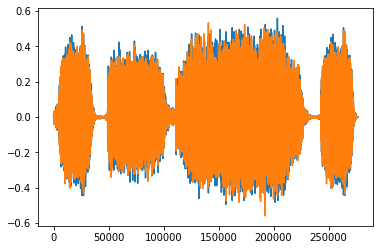

In [16]:
lowpass_waveform = torchaudio.functional.lowpass_biquad(waveform, sample_rate, cutoff_freq=3000)

print("Min of lowpass_waveform: {}\nMax of lowpass_waveform: {}\nMean of lowpass_waveform: {}".format(lowpass_waveform.min(), lowpass_waveform.max(), lowpass_waveform.mean()))

plt.figure()
plt.plot(lowpass_waveform.t().numpy())

Min of highpass_waveform: -0.11269102990627289
Max of highpass_waveform: 0.10451897978782654
Mean of highpass_waveform: -1.1749458177223726e-11


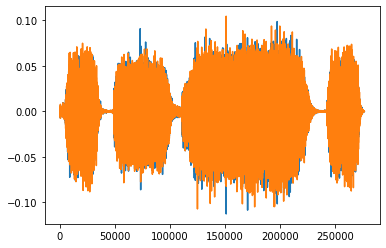

In [17]:
highpass_waveform = torchaudio.functional.highpass_biquad(waveform, sample_rate, cutoff_freq=2000)

print("Min of highpass_waveform: {}\nMax of highpass_waveform: {}\nMean of highpass_waveform: {}".format(highpass_waveform.min(), highpass_waveform.max(), highpass_waveform.mean()))

plt.figure()
plt.plot(highpass_waveform.t().numpy())

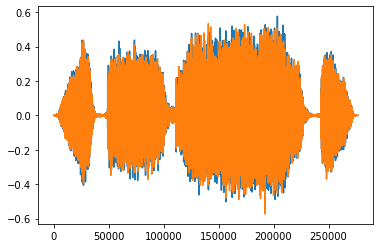

In [30]:

#stretched_tensor =torchaudio.transforms.TimeStretch()(specgram)
faded_audio= torchaudio.transforms.Fade(fade_in_len= 30000,fade_out_len=30000)(waveform)


plt.figure()
plt.plot(faded_audio.t().numpy())

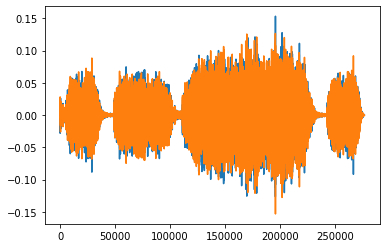

In [19]:
equalize=torchaudio.transforms.SlidingWindowCmn()(waveform)
plt.figure()
plt.plot(equalize.t().numpy())

Conclusion
----------

We used an example raw audio signal, or waveform, to illustrate how to
open an audio file using torchaudio, and how to pre-process and
transform such waveform. 

Now you are ready to put this modified waveform into your model 


